In [49]:
from sklearn.datasets import make_classification
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import duckdb as db
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.collections import QuadMesh
import matplotlib.font_manager as fm

In [50]:
df = pd.read_csv('Full_match_outcome.csv')

In [51]:
df

,Unnamed: 0,match_id,competition,season,home_team,away_team,home_score,away_score,home_win,away_win,...,t1_t1_entropy,t2_t2_entropy,t1_t2_entropy,t2_t1_entropy,total_entropy,team1_entropy_segment,team2_entropy_segment,SEI,Home_Win_Pred,away_Win_Pred
0,0,15946,La Liga,2018/2019,Barcelona,Deportivo Alavés,3,0,1,0,...,6.884968,1.652269,1.232094,1.135241,10.904572,0.622502,0.160403,0.462099,1,0
1,1,15956,La Liga,2018/2019,Real Valladolid,Barcelona,0,1,0,1,...,3.469568,4.994467,0.831541,1.223273,10.518850,0.367084,0.437570,-0.070486,0,1
2,2,15973,La Liga,2018/2019,Barcelona,Huesca,8,2,1,0,...,6.008893,2.535022,0.959982,1.002560,10.506456,0.575976,0.237230,0.338747,1,0
3,3,15978,La Liga,2018/2019,Real Sociedad,Barcelona,1,2,0,1,...,2.768963,5.638493,1.154647,1.067252,10.629355,0.252279,0.538686,-0.286407,0,1
4,4,15986,La Liga,2018/2019,Barcelona,Girona,2,2,0,0,...,5.822328,2.798942,1.165969,1.036201,10.823440,0.525947,0.270590,0.255358,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,682,9700,La Liga,2017/2018,Barcelona,Celta Vigo,2,2,0,0,...,5.502583,2.924616,1.417909,1.197818,11.042926,0.478360,0.284771,0.193589,1,0
683,683,266952,La Liga,2016/2017,Barcelona,Villarreal,4,1,1,0,...,5.298429,2.678190,1.585246,1.313722,10.875586,0.462219,0.271223,0.190996,1,0
684,684,267561,La Liga,2014/2015,Rayo Vallecano,Barcelona,0,2,0,1,...,3.190862,4.711522,1.276957,1.137066,10.316407,0.295740,0.470262,-0.174522,0,1
685,685,69243,La Liga,2009/2010,Barcelona,Sevilla,4,0,1,0,...,5.713168,2.247884,1.437068,1.291852,10.689972,0.520858,0.223864,0.296994,1,0


In [52]:
df.columns

Index(['Unnamed: 0', 'match_id', 'competition', 'season', 'home_team',
       'away_team', 'home_score', 'away_score', 'home_win', 'away_win', 'tie',
       'match_id_2', 'home_team_2', 'away_team_2', 't1_t1_entropy',
       't2_t2_entropy', 't1_t2_entropy', 't2_t1_entropy', 'total_entropy',
       'team1_entropy_segment', 'team2_entropy_segment', 'SEI',
       'Home_Win_Pred', 'away_Win_Pred'],
      dtype='object')

In [53]:
from sklearn.model_selection import train_test_split
# use index-based sampling since we have time series data
train, test = train_test_split(df, test_size=0.4, shuffle=True)

In [54]:
pred_vars = ['t1_t1_entropy','t2_t2_entropy', 't1_t2_entropy', 't2_t1_entropy']
y_var = 'home_win'

In [55]:
dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)
dtree.fit(train[pred_vars], train[y_var])

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [56]:
rf = ensemble.RandomForestClassifier(n_estimators=200)
rf.fit(train[pred_vars], train[y_var])

RandomForestClassifier(n_estimators=200)

In [57]:
mlp = MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=500, n_iter_no_change=20)
mlp.fit(train[pred_vars], train[y_var])

MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=500, n_iter_no_change=20)

In [58]:
nb = GaussianNB()
nb.fit(train[pred_vars], train[y_var])

GaussianNB()

In [59]:
lr = LogisticRegression()
lr.fit(train[pred_vars], train[y_var])

LogisticRegression()

In [60]:
knr = KNeighborsClassifier()
knr.fit(train[pred_vars], train[y_var])

KNeighborsClassifier()

In [61]:
fitted = [dtree, rf, mlp, nb, lr, knr] #took svc out, and knr, sgd

# empty dataframe to store the results
result_table = pd.DataFrame(columns=['classifier_name', 'fpr','tpr','auc', 
                                     'log_loss', 'clf_report'])

for clf in fitted:
    # print the name of the classifier
    print(clf.__class__.__name__)
    
    # get predictions

    yproba = clf.predict_proba(test[pred_vars])
    yclass = clf.predict(test[pred_vars])
    
    # auc information
    fpr, tpr, _ = metrics.roc_curve(test[y_var],  yproba[:,1])
    auc = metrics.roc_auc_score(test[y_var], yproba[:,1])
    
    # log loss
    log_loss = metrics.log_loss(test[y_var], yproba[:,1])
    
    # add some other stats based on confusion matrix
    clf_report = metrics.classification_report(test[y_var], yclass)
    
    # add the results to the dataframe
    result_table = result_table.append({'classifier_name':clf.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'log_loss': log_loss,
                                        'clf_report': clf_report}, ignore_index=True)

DecisionTreeClassifier
RandomForestClassifier
MLPClassifier
GaussianNB
LogisticRegression
KNeighborsClassifier


C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\2398073577.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifier_name':clf.__class__.__name__,
C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\2398073577.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifier_name':clf.__class__.__name__,
C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\2398073577.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifier_name':clf.__class__.__name__,
C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\2398073577.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

In [62]:
result_table.set_index('classifier_name', inplace=True)
display(result_table)

,fpr,tpr,auc,log_loss,clf_report
classifier_name,,,,,
DecisionTreeClassifier,"[0.0, 0.2328767123287671, 0.2534246575342466, ...","[0.0, 0.5658914728682171, 0.5813953488372093, ...",0.687454,8.791196,precision recall f1-score ...
RandomForestClassifier,"[0.0, 0.00684931506849315, 0.00684931506849315...","[0.0, 0.0, 0.031007751937984496, 0.04651162790...",0.808936,0.587472,precision recall f1-score ...
MLPClassifier,"[0.0, 0.0, 0.0136986301369863, 0.0136986301369...","[0.0, 0.007751937984496124, 0.0077519379844961...",0.80275,0.540629,precision recall f1-score ...
GaussianNB,"[0.0, 0.0, 0.00684931506849315, 0.006849315068...","[0.0, 0.007751937984496124, 0.0077519379844961...",0.799883,0.82003,precision recall f1-score ...
LogisticRegression,"[0.0, 0.0, 0.0, 0.00684931506849315, 0.0068493...","[0.0, 0.007751937984496124, 0.0155038759689922...",0.802272,0.547969,precision recall f1-score ...
KNeighborsClassifier,"[0.0, 0.07534246575342465, 0.17123287671232876...","[0.0, 0.31007751937984496, 0.6201550387596899,...",0.788653,3.104993,precision recall f1-score ...


In [63]:
for i in result_table.index:
    print('\n---- statistics for', i, "----\n")
    print(result_table.loc[i, 'clf_report'])
    print("Model log loss:", result_table.loc[i, 'log_loss'])


---- statistics for DecisionTreeClassifier ----

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       146
           1       0.68      0.64      0.66       129

    accuracy                           0.69       275
   macro avg       0.69      0.69      0.69       275
weighted avg       0.69      0.69      0.69       275

Model log loss: 8.791196256173054

---- statistics for RandomForestClassifier ----

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       146
           1       0.72      0.74      0.73       129

    accuracy                           0.75       275
   macro avg       0.74      0.75      0.74       275
weighted avg       0.75      0.75      0.75       275

Model log loss: 0.5874722089800447

---- statistics for MLPClassifier ----

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       146
           1       0.75    

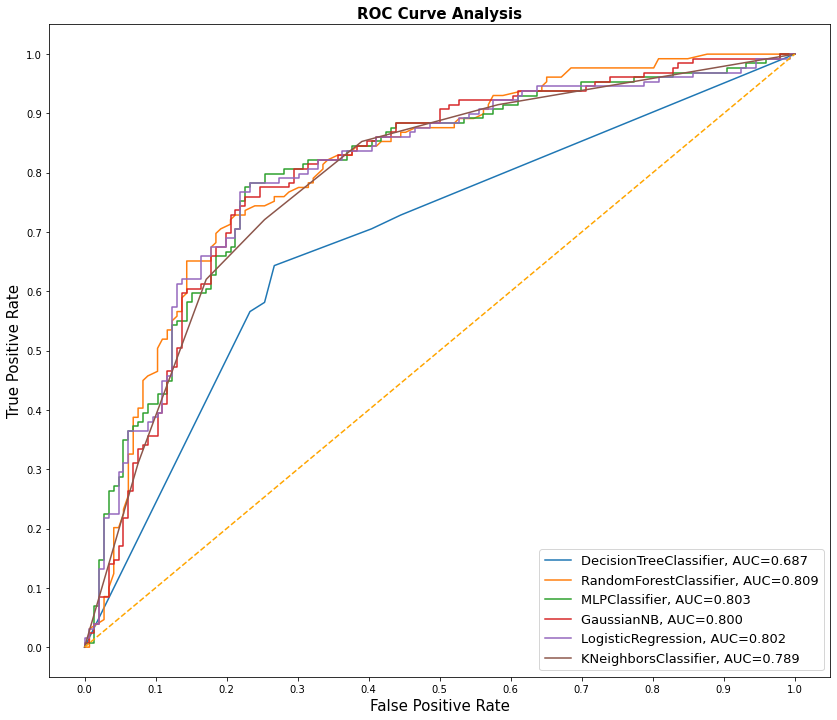

In [64]:
fig = plt.figure(figsize=(14,12))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\3307000079.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


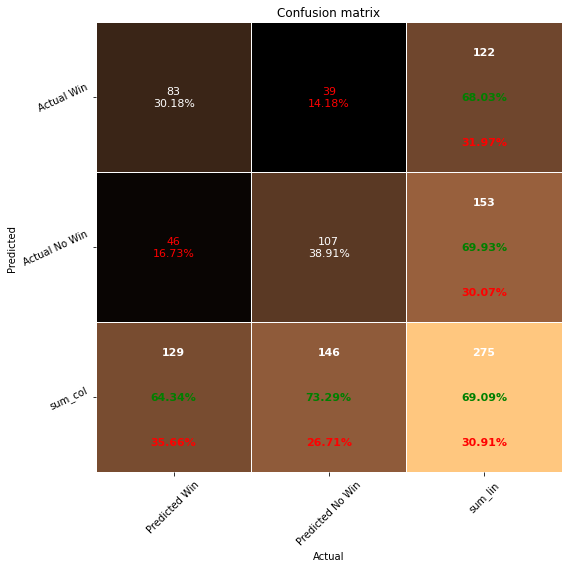

In [65]:
predicted = dtree.predict(test.loc[:, pred_vars])
cm = metrics.confusion_matrix(y_true=test[y_var], y_pred=predicted, labels=[1, 0])
df_cm = pd.DataFrame(cm,  columns=['Actual Win','Actual No Win'], index=['Predicted Win', 'Predicted No Win'])
pp_matrix(df_cm,cmap='copper', file='dtree_cm.png') #Copper

C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\3307000079.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


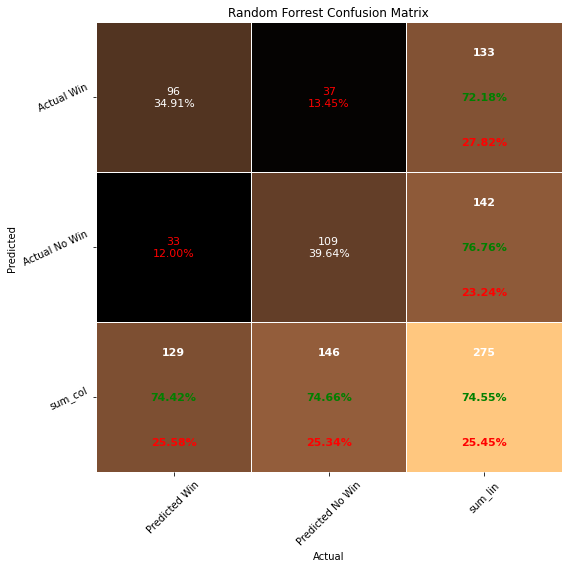

In [66]:
predicted = rf.predict(test.loc[:, pred_vars])
cm = metrics.confusion_matrix(y_true=test[y_var], y_pred=predicted, labels=[1, 0])
df_cm = pd.DataFrame(cm,  columns=['Actual Win','Actual No Win'], index=['Predicted Win', 'Predicted No Win'])
pp_matrix(df_cm,cmap='copper', title='Random Forrest Confusion Matrix', file='rf_cm.png') #Copper

C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\3307000079.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


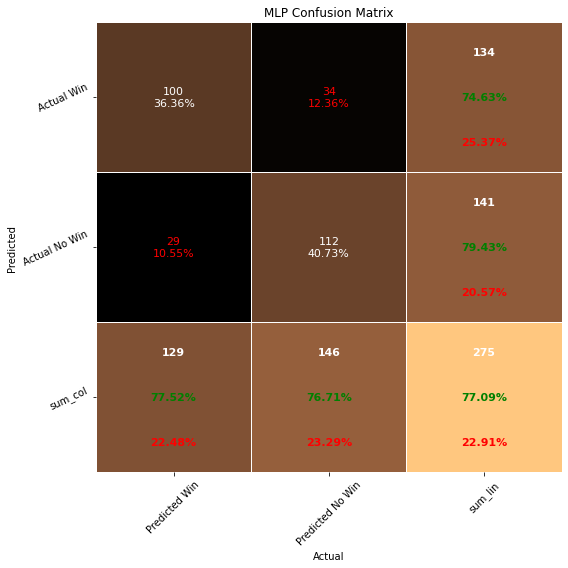

In [67]:
predicted = mlp.predict(test.loc[:, pred_vars])
cm = metrics.confusion_matrix(y_true=test[y_var], y_pred=predicted, labels=[1, 0])
df_cm = pd.DataFrame(cm,  columns=['Actual Win','Actual No Win'], index=['Predicted Win', 'Predicted No Win'])
pp_matrix(df_cm,cmap='copper', title='MLP Confusion Matrix', file='MLP_cm.png') #Copper

C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\3307000079.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


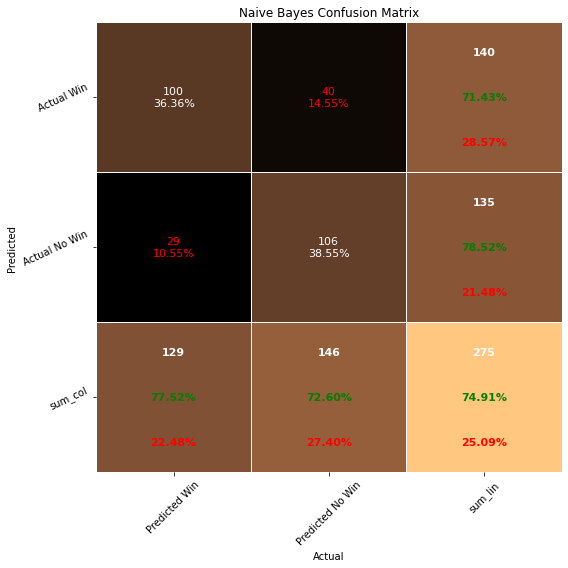

In [68]:
predicted = nb.predict(test.loc[:, pred_vars])
cm = metrics.confusion_matrix(y_true=test[y_var], y_pred=predicted, labels=[1, 0])
df_cm = pd.DataFrame(cm,  columns=['Actual Win','Actual No Win'], index=['Predicted Win', 'Predicted No Win'])
pp_matrix(df_cm,cmap='copper', title='Naive Bayes Confusion Matrix', file='nb_cm.png') #Copper

C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\3307000079.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


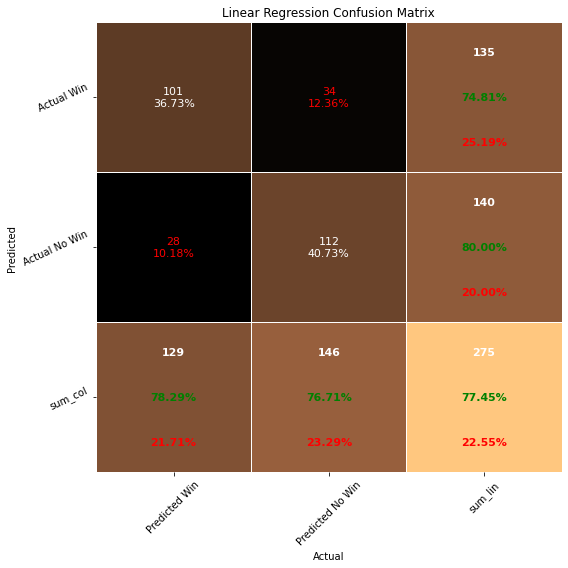

In [69]:
predicted = lr.predict(test.loc[:, pred_vars])
cm = metrics.confusion_matrix(y_true=test[y_var], y_pred=predicted, labels=[1, 0])
df_cm = pd.DataFrame(cm,  columns=['Actual Win','Actual No Win'], index=['Predicted Win', 'Predicted No Win'])
pp_matrix(df_cm,cmap='copper', title='Logistic Regression Confusion Matrix', file='lr_cm.png') #Copper

C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\3307000079.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


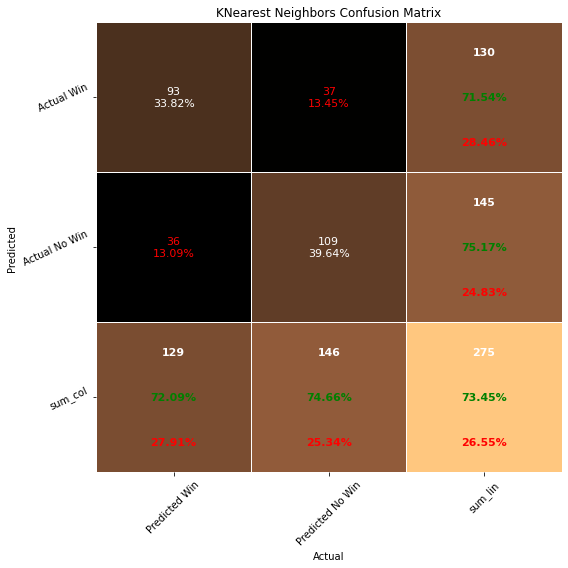

In [70]:
predicted = knr.predict(test.loc[:, pred_vars])
cm = metrics.confusion_matrix(y_true=test[y_var], y_pred=predicted, labels=[1, 0])
df_cm = pd.DataFrame(cm,  columns=['Actual Win','Actual No Win'], index=['Predicted Win', 'Predicted No Win'])
pp_matrix(df_cm,cmap='copper', title='KNearest Neighbors Confusion Matrix', file='knr_cm.png') #Copper

C:\Users\jacks\AppData\Local\Temp\ipykernel_28972\3307000079.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


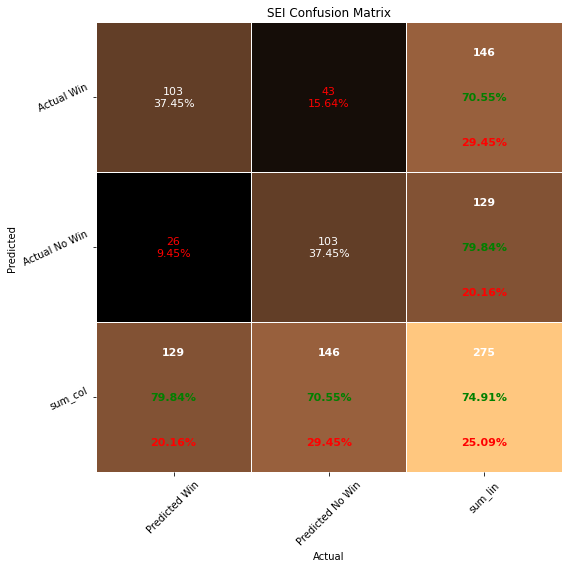

In [71]:
predicted = test['Home_Win_Pred']
cm = metrics.confusion_matrix(y_true=test[y_var], y_pred=predicted, labels=[1, 0])
df_cm = pd.DataFrame(cm,  columns=['Actual Win','Actual No Win'], index=['Predicted Win', 'Predicted No Win'])
pp_matrix(df_cm,cmap='copper', title='SEI Confusion Matrix', file='SEI_cm.png') #Copper

In [73]:
def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)

    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def get_new_fig(fn, figsize=[9, 9]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1

def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col
    
def pp_matrix(
    df_cm,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="y",
    title="Confusion matrix",
    file=''
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print allways in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": fz},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1

        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values
        )

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    ax.set_title(title)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  # set layout slim
    plt.show()
    if file != '':
        fig.savefig(file) 